# Random Forest Test

* Sử dụng Bayesian để tìm tham số
* bỏ sii = null

Best parameters: OrderedDict([('classifier__bootstrap', True), ('classifier__criterion', 'gini'), ('classifier__max_depth', 10), ('classifier__max_features', None), ('classifier__min_samples_leaf', 1), ('classifier__min_samples_split', 19), ('classifier__n_estimators', 497)])
Best cross-validation score: 0.565039318777999


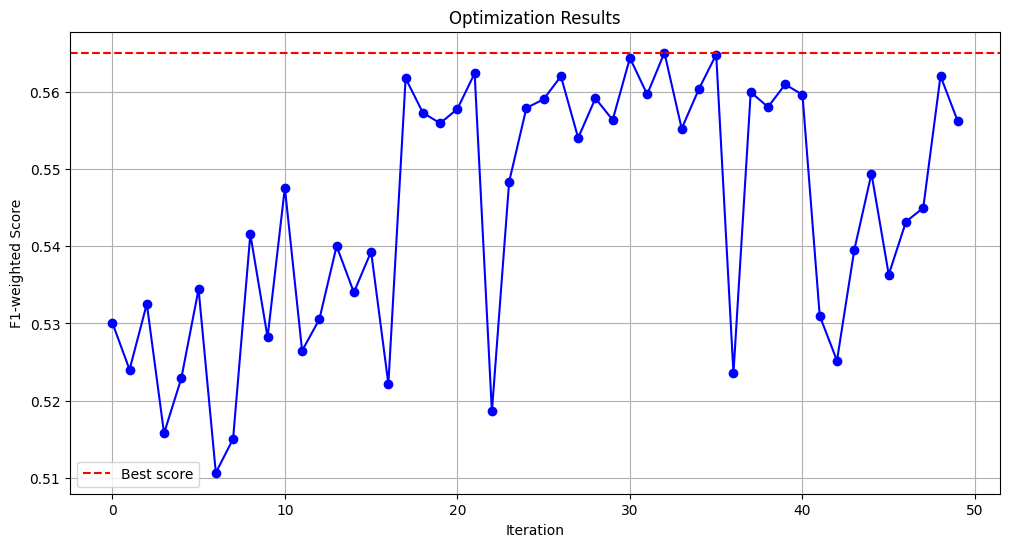

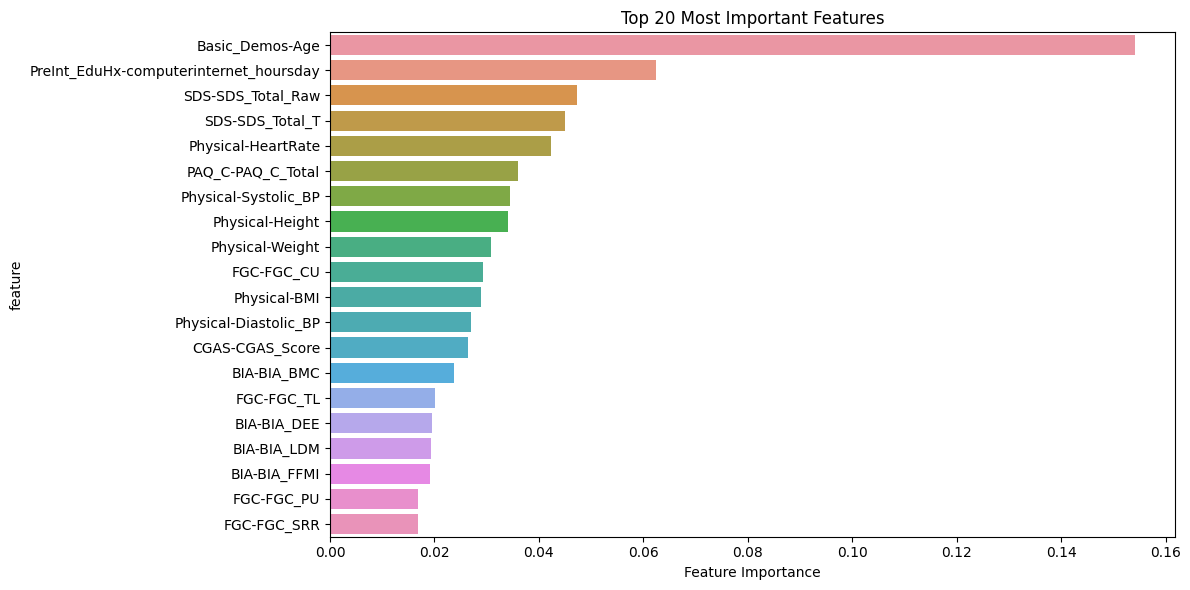

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import joblib

warnings.filterwarnings('ignore', category=FutureWarning)

# Đọc dữ liệu
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

# Loại bỏ các hàng có giá trị thiếu trong biến mục tiêu 'sii'
train = train.dropna(subset=['sii'])

# Bỏ các cột sii, id và cả PCIAT_PCIAT_*
X = train.drop(columns=['sii', 'id'] + [col for col in train.columns if 'PCIAT' in col])
y = train['sii']

# Kiểm tra và mã hóa các cột chuỗi trong tập huấn luyện
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column].astype(str))

# Tạo pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Định nghĩa K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Định nghĩa không gian tìm kiếm
search_spaces = {
    'classifier__n_estimators': Integer(50, 500),
    'classifier__max_depth': Categorical([None] + list(range(10, 50, 5))),
    'classifier__min_samples_split': Integer(2, 20),
    'classifier__min_samples_leaf': Integer(1, 10),
    'classifier__max_features': Categorical(['sqrt', 'log2', None]),
    'classifier__criterion': Categorical(['gini', 'entropy']),
    'classifier__bootstrap': Categorical([True, False])
}

# Khởi tạo BayesSearchCV với thứ tự tham số đúng
bayes_search = BayesSearchCV(
    pipeline,
    search_spaces,
    n_jobs=-1,
    cv=kfold,
    n_iter=50,
    scoring='f1_weighted',
    verbose=0,
    random_state=42
)

# Thực hiện tìm kiếm
bayes_search.fit(X, y)

# In kết quả
print("Best parameters:", bayes_search.best_params_)
print("Best cross-validation score:", bayes_search.best_score_)

# Lưu mô hình tốt nhất
joblib.dump(bayes_search.best_estimator_, 'best_rf_model.joblib')

# Chuẩn bị dữ liệu test
test_X = test.drop(columns=['id'] + [col for col in test.columns if 'PCIAT' in col])

# Kiểm tra và mã hóa các cột chuỗi trong tập test
for column in test_X.columns:
    if test_X[column].dtype == 'object':
        test_X[column] = label_encoder.fit_transform(test_X[column].astype(str))

# Dự đoán trên tập dữ liệu test
test_predictions = bayes_search.predict(test_X)

# Tạo file submission
submission = pd.DataFrame({
    'id': test['id'],
    'sii': test_predictions
})

submission.to_csv('submission.csv', index=False)

# Vẽ đồ thị quá trình tối ưu
def plot_optimization_results(bayes_search):
    plt.figure(figsize=(12, 6))
    
    # Lấy điểm số của tất cả các lần thử
    results = bayes_search.cv_results_
    scores = results['mean_test_score']
    iterations = range(len(scores))
    
    # Vẽ điểm số theo số lần lặp
    plt.plot(iterations, scores, 'bo-')
    plt.axhline(y=bayes_search.best_score_, color='r', linestyle='--', label='Best score')
    
    plt.xlabel('Iteration')
    plt.ylabel('F1-weighted Score')
    plt.title('Optimization Results')
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ đồ thị kết quả tối ưu hóa
plot_optimization_results(bayes_search)

# Phân tích tầm quan trọng của các đặc trưng
best_rf = bayes_search.best_estimator_.named_steps['classifier']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Vẽ biểu đồ tầm quan trọng của đặc trưng
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()